我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382



1. **数据预处理方面的问题**：
```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/06-TCN-单独计算藻密度-dropout-better+his-density copy.ipynb
def preprocess_data(df, sequence_length, max_prediction_step=7):
    # ... existing code ...
    
    # 建议修改：增加历史藻密度的权重
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    
    # 可以添加更多最近的历史数据点
    df['density_mean_y_1d'] = df['density_mean_y'].shift(1)
    df['density_mean_y_2d'] = df['density_mean_y'].shift(2)
    df['density_mean_y_3d'] = df['density_mean_y'].shift(3)
    
    history_features.extend(['density_mean_y_1d', 'density_mean_y_2d', 'density_mean_y_3d'])
```

2. **模型结构的改进**：
```python
class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        
        # 添加注意力机制，特别关注最近的历史数据
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        
        # 增加残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # ... rest of the code ...
    
    def forward(self, x):
        # ... existing code ...
        
        # 添加残差连接，特别是对最近的历史数据
        residual = self.residual(x[:, -1, :])
        out = out + residual
        
        return out
```

3. **训练参数的调整**：
```python
def main():
    # ... existing code ...
    
    # 修改训练参数
    batch_size = 16  # 减小批量大小，增加模型对每个样本的敏感度
    hidden_size = 256  # 增加模型容量
    learning_rate = 0.001  # 调整学习率
    
    # 使用更适合时序预测的损失函数
    criterion = nn.MSELoss()  # 或者使用自定义的损失函数，更注重短期预测准确性
```


2024-11-15 20:53:15,188 - INFO - Successfully loaded data file


2024-11-15 20:53:15,190 - INFO - 开始加载数据并预处理...
2024-11-15 20:53:15,209 - INFO - 环境特征数量: 10
2024-11-15 20:53:15,210 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-15 20:53:15,211 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-15 20:53:15,813 - INFO - 输入特征维度: 16
2024-11-15 20:53:15,814 - INFO - 
训练提前1天预报模型
2024-11-15 20:53:28,584 - INFO - Epoch 10/200, Average Loss: 0.0707
2024-11-15 20:53:38,028 - INFO - Epoch 20/200, Average Loss: 0.0251
2024-11-15 20:53:49,743 - INFO - Epoch 30/200, Average Loss: 0.0134
2024-11-15 20:54:00,539 - INFO - Epoch 40/200, Average Loss: 0.0057
2024-11-15 20:54:09,043 - INFO - Epoch 50/200, Average Loss: 0.0039
2024-11-15 20:54:19,625 - INFO - Epoch 60/200, Average Loss: 0.0023
2024-11-15 20:54:29,642 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 20:54:39,171 - INFO - Epoch 80/200, Aver

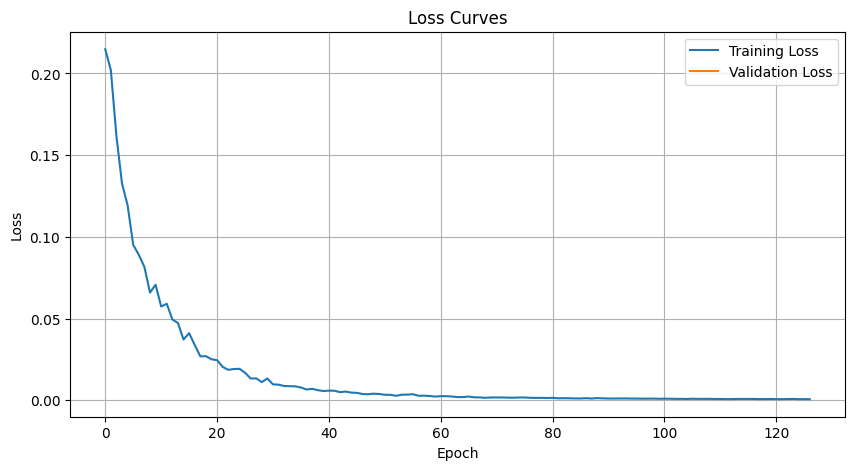

2024-11-15 20:55:28,535 - INFO - Final training loss: 0.0007
2024-11-15 20:55:28,588 - INFO - 提前1天预报 - RMSE: 0.0705, MAE: 0.0595
2024-11-15 20:55:28,589 - INFO - 
训练提前2天预报模型
2024-11-15 20:55:40,540 - INFO - Epoch 10/200, Average Loss: 0.0737
2024-11-15 20:55:51,396 - INFO - Epoch 20/200, Average Loss: 0.0273
2024-11-15 20:56:01,026 - INFO - Epoch 30/200, Average Loss: 0.0151
2024-11-15 20:56:10,782 - INFO - Epoch 40/200, Average Loss: 0.0084
2024-11-15 20:56:22,294 - INFO - Epoch 50/200, Average Loss: 0.0048
2024-11-15 20:56:34,370 - INFO - Epoch 60/200, Average Loss: 0.0028
2024-11-15 20:56:44,207 - INFO - Epoch 70/200, Average Loss: 0.0019
2024-11-15 20:56:55,388 - INFO - Epoch 80/200, Average Loss: 0.0018
2024-11-15 20:57:05,388 - INFO - Epoch 90/200, Average Loss: 0.0015
2024-11-15 20:57:15,842 - INFO - Epoch 100/200, Average Loss: 0.0010
2024-11-15 20:57:25,227 - INFO - Epoch 110/200, Average Loss: 0.0009
2024-11-15 20:57:33,540 - INFO - Epoch 120/200, Average Loss: 0.0008
2024-11

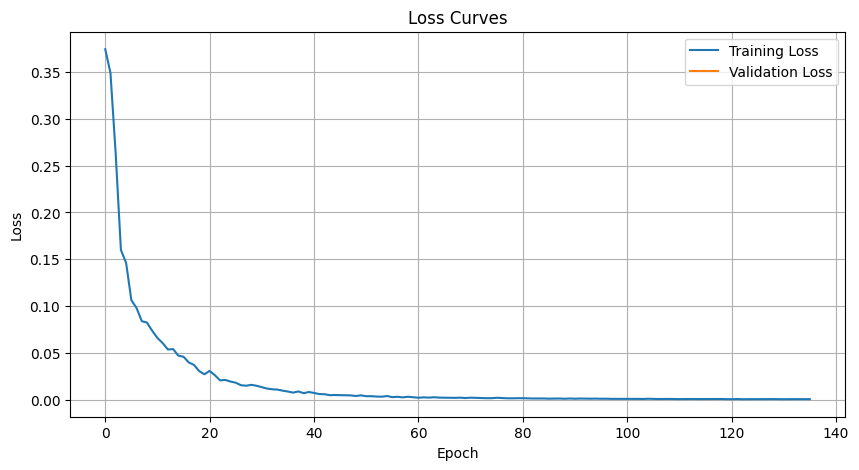

2024-11-15 20:57:50,434 - INFO - Final training loss: 0.0008
2024-11-15 20:57:50,485 - INFO - 提前2天预报 - RMSE: 0.0513, MAE: 0.0410
2024-11-15 20:57:50,489 - INFO - 
训练提前3天预报模型
2024-11-15 20:58:02,171 - INFO - Epoch 10/200, Average Loss: 0.0397
2024-11-15 20:58:12,913 - INFO - Epoch 20/200, Average Loss: 0.0174
2024-11-15 20:58:23,668 - INFO - Epoch 30/200, Average Loss: 0.0092
2024-11-15 20:58:34,800 - INFO - Epoch 40/200, Average Loss: 0.0056
2024-11-15 20:58:44,780 - INFO - Epoch 50/200, Average Loss: 0.0036
2024-11-15 20:58:56,131 - INFO - Epoch 60/200, Average Loss: 0.0020
2024-11-15 20:59:06,978 - INFO - Epoch 70/200, Average Loss: 0.0015
2024-11-15 20:59:17,217 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 20:59:28,964 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 20:59:39,058 - INFO - Epoch 100/200, Average Loss: 0.0011
2024-11-15 20:59:48,684 - INFO - Epoch 110/200, Average Loss: 0.0008
2024-11-15 20:59:59,556 - INFO - Epoch 120/200, Average Loss: 0.0007
2024-11

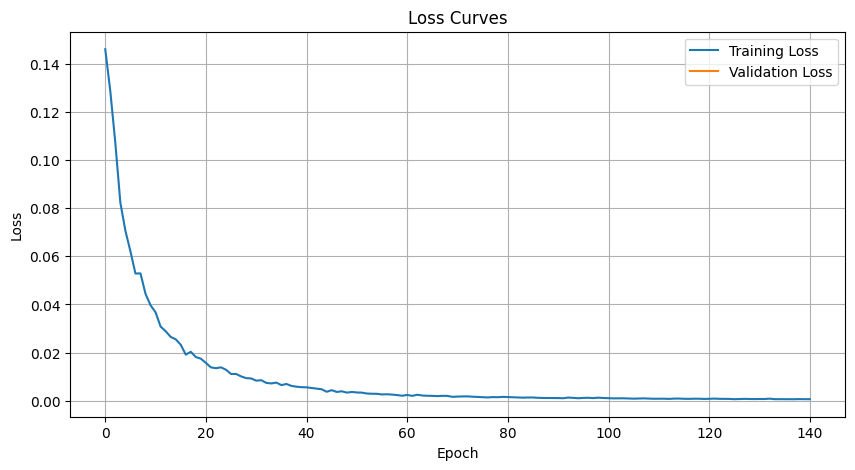

2024-11-15 21:00:22,437 - INFO - Final training loss: 0.0006
2024-11-15 21:00:22,507 - INFO - 提前3天预报 - RMSE: 0.0507, MAE: 0.0414
2024-11-15 21:00:22,509 - INFO - 
训练提前4天预报模型
2024-11-15 21:00:33,023 - INFO - Epoch 10/200, Average Loss: 0.0414
2024-11-15 21:00:44,962 - INFO - Epoch 20/200, Average Loss: 0.0160
2024-11-15 21:00:55,710 - INFO - Epoch 30/200, Average Loss: 0.0099
2024-11-15 21:01:04,671 - INFO - Epoch 40/200, Average Loss: 0.0042
2024-11-15 21:01:13,255 - INFO - Epoch 50/200, Average Loss: 0.0034
2024-11-15 21:01:21,565 - INFO - Epoch 60/200, Average Loss: 0.0024
2024-11-15 21:01:30,637 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 21:01:41,226 - INFO - Epoch 80/200, Average Loss: 0.0014
2024-11-15 21:01:51,395 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:02:02,057 - INFO - Epoch 100/200, Average Loss: 0.0009
2024-11-15 21:02:12,648 - INFO - Early stopping at epoch 109


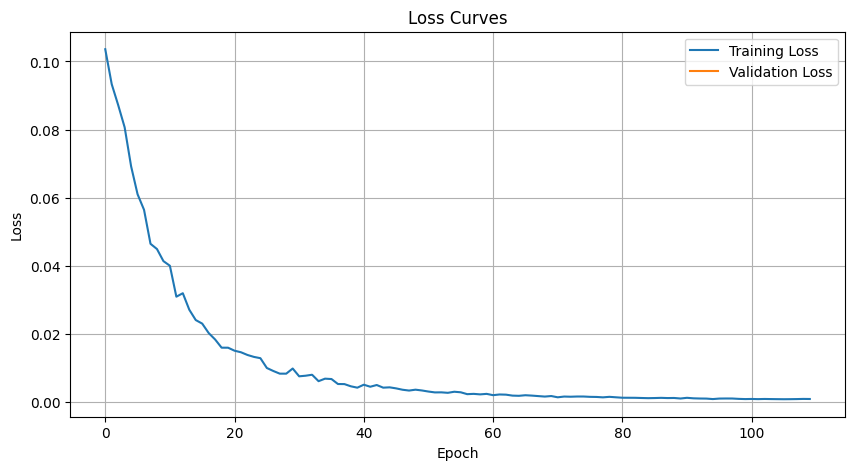

2024-11-15 21:02:12,818 - INFO - Final training loss: 0.0009
2024-11-15 21:02:12,937 - INFO - 提前4天预报 - RMSE: 0.1050, MAE: 0.0791
2024-11-15 21:02:12,941 - INFO - 
训练提前5天预报模型
2024-11-15 21:02:23,500 - INFO - Epoch 10/200, Average Loss: 0.0510
2024-11-15 21:02:33,569 - INFO - Epoch 20/200, Average Loss: 0.0248
2024-11-15 21:02:44,602 - INFO - Epoch 30/200, Average Loss: 0.0121
2024-11-15 21:02:54,443 - INFO - Epoch 40/200, Average Loss: 0.0064
2024-11-15 21:03:05,753 - INFO - Epoch 50/200, Average Loss: 0.0045
2024-11-15 21:03:15,718 - INFO - Epoch 60/200, Average Loss: 0.0029
2024-11-15 21:03:26,468 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 21:03:36,492 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 21:03:45,466 - INFO - Epoch 90/200, Average Loss: 0.0013
2024-11-15 21:03:56,575 - INFO - Epoch 100/200, Average Loss: 0.0012
2024-11-15 21:04:07,172 - INFO - Epoch 110/200, Average Loss: 0.0010
2024-11-15 21:04:18,341 - INFO - Epoch 120/200, Average Loss: 0.0009
2024-11

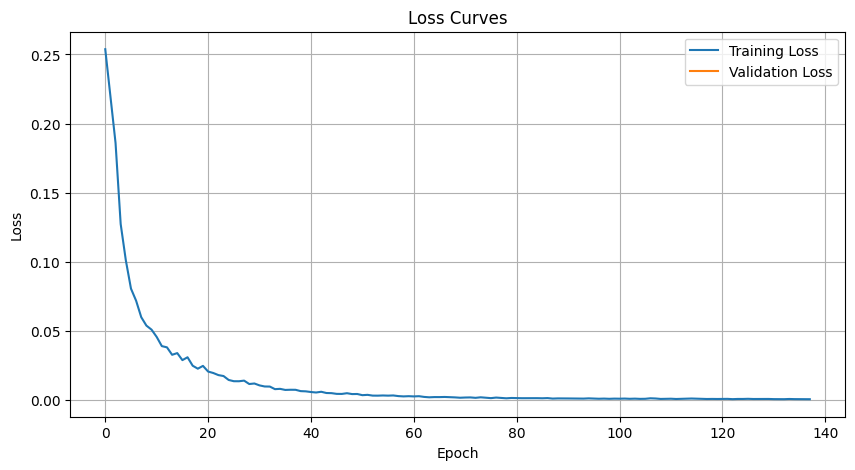

2024-11-15 21:04:41,425 - INFO - Final training loss: 0.0007
2024-11-15 21:04:41,570 - INFO - 提前5天预报 - RMSE: 0.0440, MAE: 0.0337
2024-11-15 21:04:41,571 - INFO - 
训练提前6天预报模型
2024-11-15 21:04:51,028 - INFO - Epoch 10/200, Average Loss: 0.0431
2024-11-15 21:04:59,726 - INFO - Epoch 20/200, Average Loss: 0.0168
2024-11-15 21:05:08,511 - INFO - Epoch 30/200, Average Loss: 0.0077
2024-11-15 21:05:17,024 - INFO - Epoch 40/200, Average Loss: 0.0051
2024-11-15 21:05:24,540 - INFO - Epoch 50/200, Average Loss: 0.0030
2024-11-15 21:05:32,894 - INFO - Epoch 60/200, Average Loss: 0.0020
2024-11-15 21:05:41,136 - INFO - Epoch 70/200, Average Loss: 0.0019
2024-11-15 21:05:49,340 - INFO - Epoch 80/200, Average Loss: 0.0014
2024-11-15 21:05:55,700 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:06:02,178 - INFO - Epoch 100/200, Average Loss: 0.0010
2024-11-15 21:06:08,784 - INFO - Epoch 110/200, Average Loss: 0.0009
2024-11-15 21:06:15,440 - INFO - Epoch 120/200, Average Loss: 0.0008
2024-11

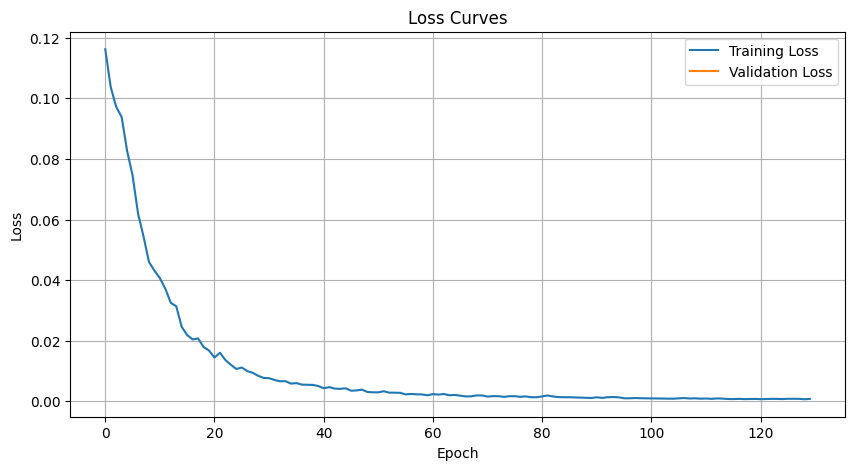

2024-11-15 21:06:22,305 - INFO - Final training loss: 0.0008
2024-11-15 21:06:22,394 - INFO - 提前6天预报 - RMSE: 0.0615, MAE: 0.0471
2024-11-15 21:06:22,394 - INFO - 
训练提前7天预报模型
2024-11-15 21:06:29,288 - INFO - Epoch 10/200, Average Loss: 0.0306
2024-11-15 21:06:35,912 - INFO - Epoch 20/200, Average Loss: 0.0160
2024-11-15 21:06:42,663 - INFO - Epoch 30/200, Average Loss: 0.0084
2024-11-15 21:06:49,091 - INFO - Epoch 40/200, Average Loss: 0.0055
2024-11-15 21:06:55,691 - INFO - Epoch 50/200, Average Loss: 0.0033
2024-11-15 21:07:03,364 - INFO - Epoch 60/200, Average Loss: 0.0021
2024-11-15 21:07:11,001 - INFO - Epoch 70/200, Average Loss: 0.0017
2024-11-15 21:07:18,176 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 21:07:24,859 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:07:32,235 - INFO - Epoch 100/200, Average Loss: 0.0012
2024-11-15 21:07:37,086 - INFO - Early stopping at epoch 106


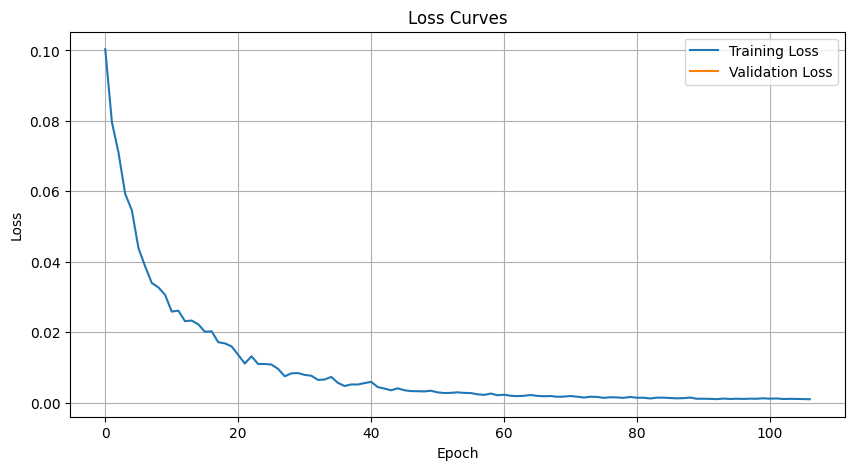

2024-11-15 21:07:37,217 - INFO - Final training loss: 0.0009
2024-11-15 21:07:37,260 - INFO - 提前7天预报 - RMSE: 0.0467, MAE: 0.0363
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/

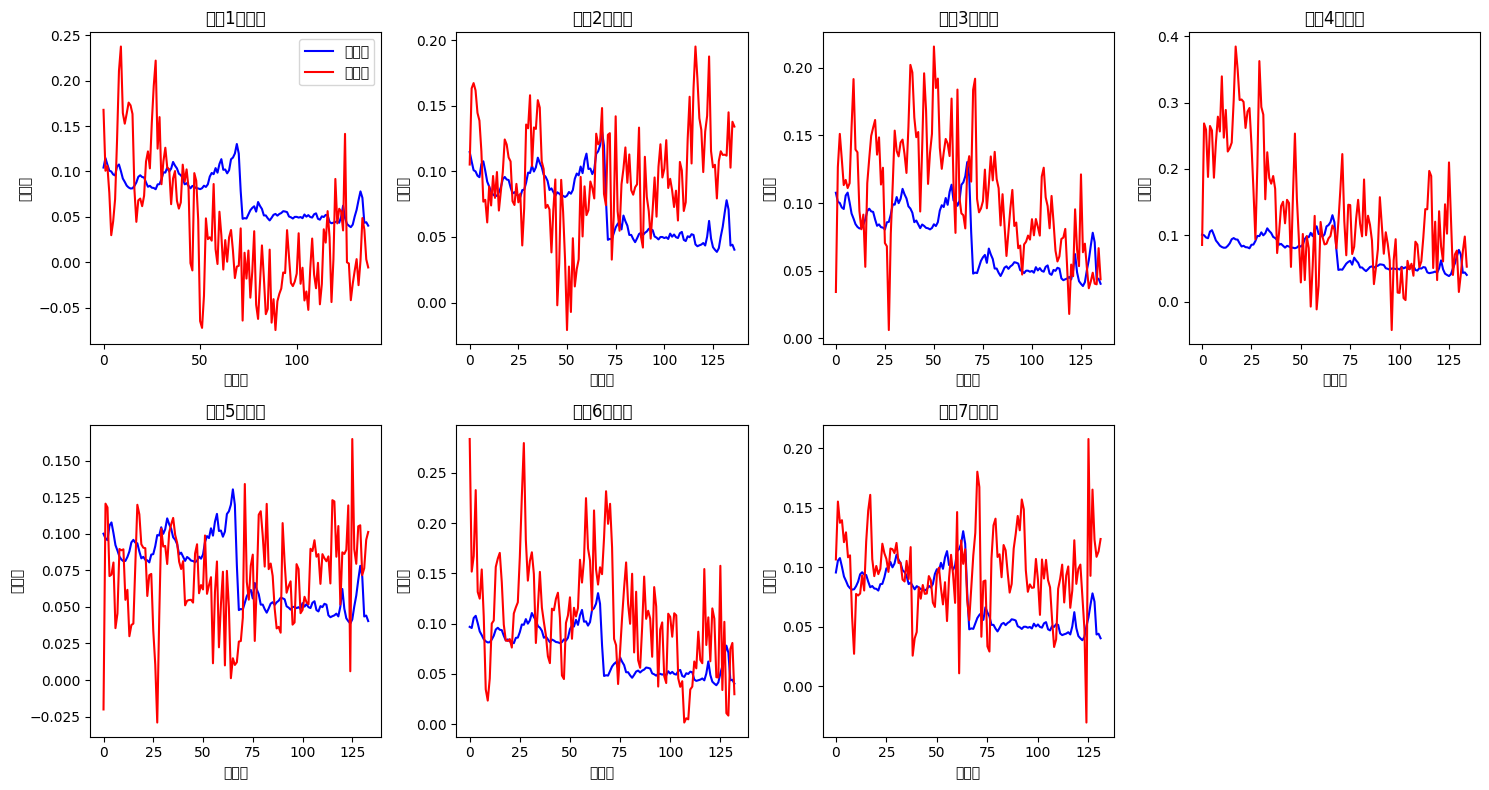

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

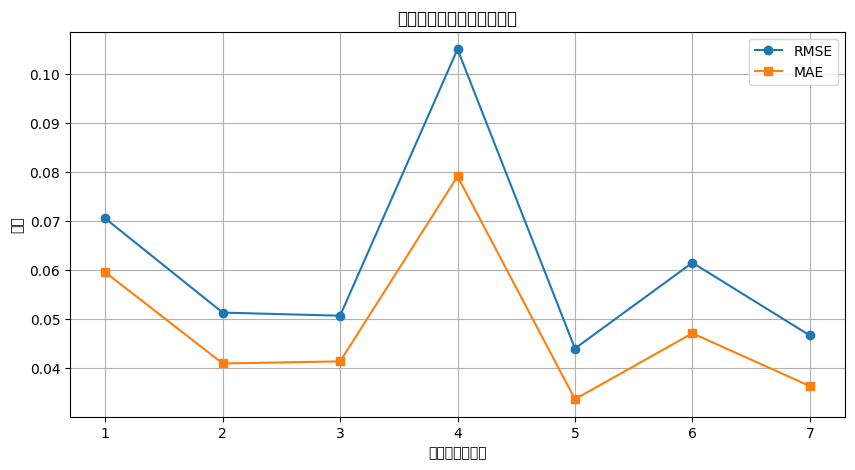

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        if out.size(2) != residual.size(2):
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 添加注意力机制，特别关注最近的历史数据
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        
        # 增加残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        out = self.tcn(x)
        
        # 应用注意力机制
        out = out.transpose(1, 2)  # 调整维度以适应注意力层
        attn_out, _ = self.attention(out, out, out)
        out = attn_out[:, -1, :]  # 取最后一个时间步
        
        out = self.fc_layers(out)
        
        # 添加残差连接，特别是对最近的历史数据
        residual = self.residual(x[:, :, -1])
        out = out + residual
        
        return out

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对所有特征进行归一化
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                           columns=all_features, 
                           index=df.index)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
    
    return train_data_dict, test_data_dict, scaler, all_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = nn.HuberLoss()
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)  # 输入特征维度会增加
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = TCNModel(input_size, hidden_size, num_layers, output_size, 
                           kernel_size=3, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()

2024-11-15 20:53:15,188 - INFO - Successfully loaded data file


2024-11-15 20:53:15,190 - INFO - 开始加载数据并预处理...
2024-11-15 20:53:15,209 - INFO - 环境特征数量: 10
2024-11-15 20:53:15,210 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-15 20:53:15,211 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-15 20:53:15,813 - INFO - 输入特征维度: 16
2024-11-15 20:53:15,814 - INFO - 
训练提前1天预报模型
2024-11-15 20:53:28,584 - INFO - Epoch 10/200, Average Loss: 0.0707
2024-11-15 20:53:38,028 - INFO - Epoch 20/200, Average Loss: 0.0251
2024-11-15 20:53:49,743 - INFO - Epoch 30/200, Average Loss: 0.0134
2024-11-15 20:54:00,539 - INFO - Epoch 40/200, Average Loss: 0.0057
2024-11-15 20:54:09,043 - INFO - Epoch 50/200, Average Loss: 0.0039
2024-11-15 20:54:19,625 - INFO - Epoch 60/200, Average Loss: 0.0023
2024-11-15 20:54:29,642 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 20:54:39,171 - INFO - Epoch 80/200, Aver

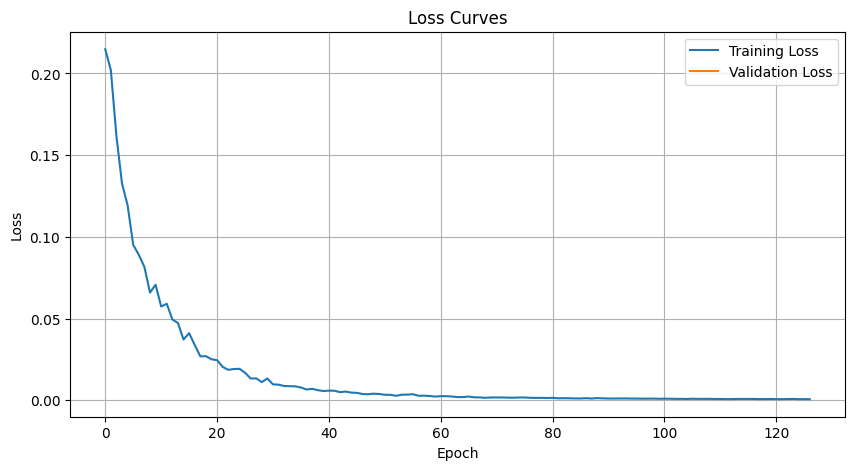

2024-11-15 20:55:28,535 - INFO - Final training loss: 0.0007
2024-11-15 20:55:28,588 - INFO - 提前1天预报 - RMSE: 0.0705, MAE: 0.0595
2024-11-15 20:55:28,589 - INFO - 
训练提前2天预报模型
2024-11-15 20:55:40,540 - INFO - Epoch 10/200, Average Loss: 0.0737
2024-11-15 20:55:51,396 - INFO - Epoch 20/200, Average Loss: 0.0273
2024-11-15 20:56:01,026 - INFO - Epoch 30/200, Average Loss: 0.0151
2024-11-15 20:56:10,782 - INFO - Epoch 40/200, Average Loss: 0.0084
2024-11-15 20:56:22,294 - INFO - Epoch 50/200, Average Loss: 0.0048
2024-11-15 20:56:34,370 - INFO - Epoch 60/200, Average Loss: 0.0028
2024-11-15 20:56:44,207 - INFO - Epoch 70/200, Average Loss: 0.0019
2024-11-15 20:56:55,388 - INFO - Epoch 80/200, Average Loss: 0.0018
2024-11-15 20:57:05,388 - INFO - Epoch 90/200, Average Loss: 0.0015
2024-11-15 20:57:15,842 - INFO - Epoch 100/200, Average Loss: 0.0010
2024-11-15 20:57:25,227 - INFO - Epoch 110/200, Average Loss: 0.0009
2024-11-15 20:57:33,540 - INFO - Epoch 120/200, Average Loss: 0.0008
2024-11

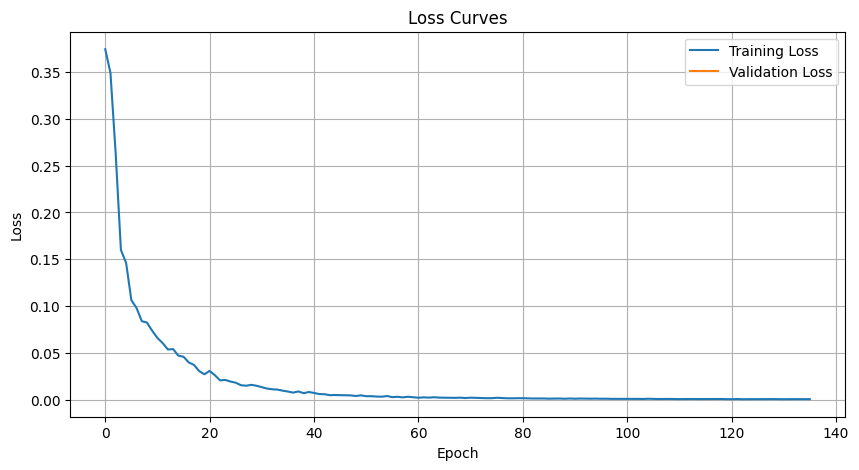

2024-11-15 20:57:50,434 - INFO - Final training loss: 0.0008
2024-11-15 20:57:50,485 - INFO - 提前2天预报 - RMSE: 0.0513, MAE: 0.0410
2024-11-15 20:57:50,489 - INFO - 
训练提前3天预报模型
2024-11-15 20:58:02,171 - INFO - Epoch 10/200, Average Loss: 0.0397
2024-11-15 20:58:12,913 - INFO - Epoch 20/200, Average Loss: 0.0174
2024-11-15 20:58:23,668 - INFO - Epoch 30/200, Average Loss: 0.0092
2024-11-15 20:58:34,800 - INFO - Epoch 40/200, Average Loss: 0.0056
2024-11-15 20:58:44,780 - INFO - Epoch 50/200, Average Loss: 0.0036
2024-11-15 20:58:56,131 - INFO - Epoch 60/200, Average Loss: 0.0020
2024-11-15 20:59:06,978 - INFO - Epoch 70/200, Average Loss: 0.0015
2024-11-15 20:59:17,217 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 20:59:28,964 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 20:59:39,058 - INFO - Epoch 100/200, Average Loss: 0.0011
2024-11-15 20:59:48,684 - INFO - Epoch 110/200, Average Loss: 0.0008
2024-11-15 20:59:59,556 - INFO - Epoch 120/200, Average Loss: 0.0007
2024-11

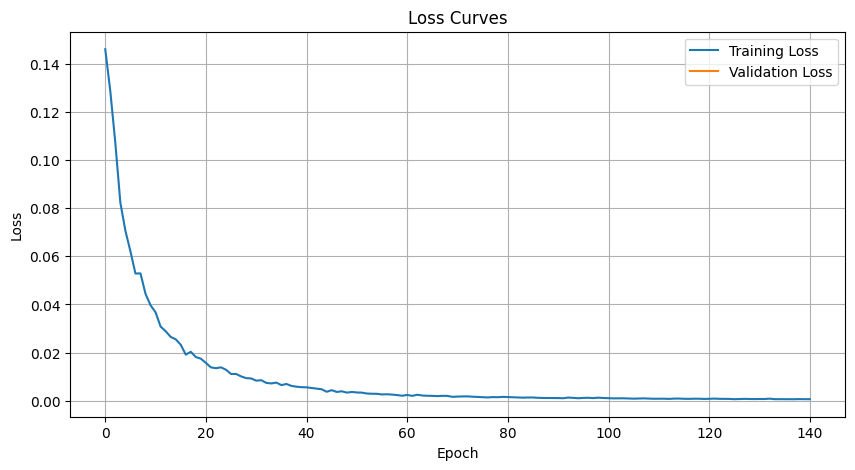

2024-11-15 21:00:22,437 - INFO - Final training loss: 0.0006
2024-11-15 21:00:22,507 - INFO - 提前3天预报 - RMSE: 0.0507, MAE: 0.0414
2024-11-15 21:00:22,509 - INFO - 
训练提前4天预报模型
2024-11-15 21:00:33,023 - INFO - Epoch 10/200, Average Loss: 0.0414
2024-11-15 21:00:44,962 - INFO - Epoch 20/200, Average Loss: 0.0160
2024-11-15 21:00:55,710 - INFO - Epoch 30/200, Average Loss: 0.0099
2024-11-15 21:01:04,671 - INFO - Epoch 40/200, Average Loss: 0.0042
2024-11-15 21:01:13,255 - INFO - Epoch 50/200, Average Loss: 0.0034
2024-11-15 21:01:21,565 - INFO - Epoch 60/200, Average Loss: 0.0024
2024-11-15 21:01:30,637 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 21:01:41,226 - INFO - Epoch 80/200, Average Loss: 0.0014
2024-11-15 21:01:51,395 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:02:02,057 - INFO - Epoch 100/200, Average Loss: 0.0009
2024-11-15 21:02:12,648 - INFO - Early stopping at epoch 109


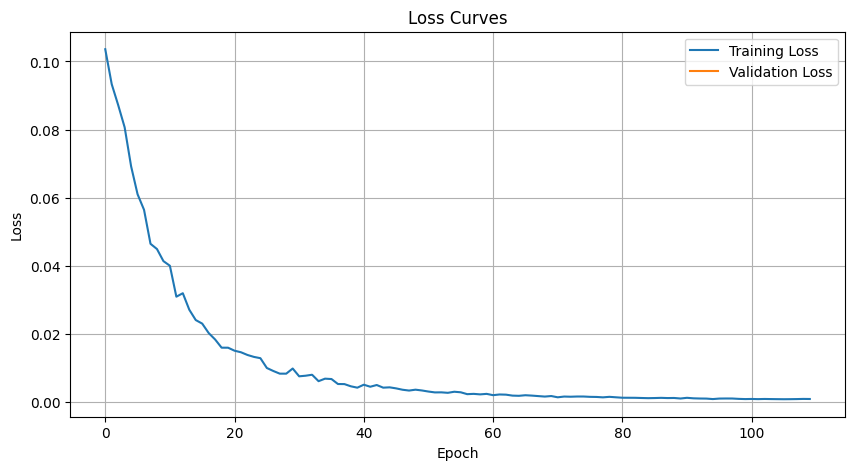

2024-11-15 21:02:12,818 - INFO - Final training loss: 0.0009
2024-11-15 21:02:12,937 - INFO - 提前4天预报 - RMSE: 0.1050, MAE: 0.0791
2024-11-15 21:02:12,941 - INFO - 
训练提前5天预报模型
2024-11-15 21:02:23,500 - INFO - Epoch 10/200, Average Loss: 0.0510
2024-11-15 21:02:33,569 - INFO - Epoch 20/200, Average Loss: 0.0248
2024-11-15 21:02:44,602 - INFO - Epoch 30/200, Average Loss: 0.0121
2024-11-15 21:02:54,443 - INFO - Epoch 40/200, Average Loss: 0.0064
2024-11-15 21:03:05,753 - INFO - Epoch 50/200, Average Loss: 0.0045
2024-11-15 21:03:15,718 - INFO - Epoch 60/200, Average Loss: 0.0029
2024-11-15 21:03:26,468 - INFO - Epoch 70/200, Average Loss: 0.0018
2024-11-15 21:03:36,492 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 21:03:45,466 - INFO - Epoch 90/200, Average Loss: 0.0013
2024-11-15 21:03:56,575 - INFO - Epoch 100/200, Average Loss: 0.0012
2024-11-15 21:04:07,172 - INFO - Epoch 110/200, Average Loss: 0.0010
2024-11-15 21:04:18,341 - INFO - Epoch 120/200, Average Loss: 0.0009
2024-11

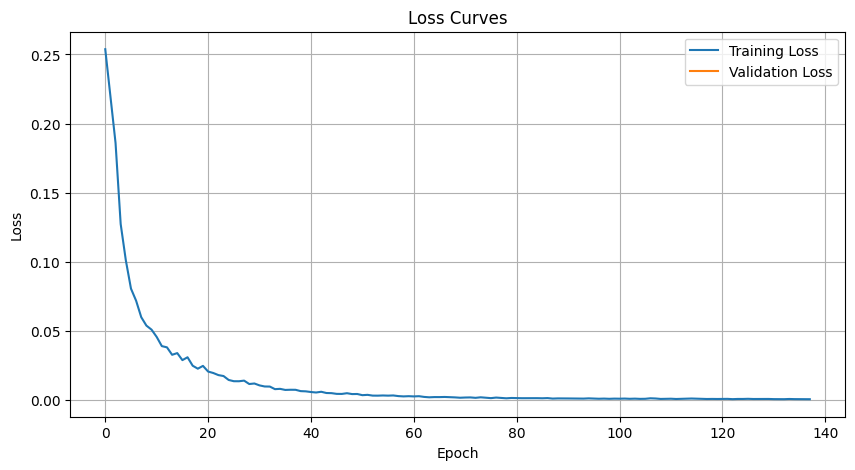

2024-11-15 21:04:41,425 - INFO - Final training loss: 0.0007
2024-11-15 21:04:41,570 - INFO - 提前5天预报 - RMSE: 0.0440, MAE: 0.0337
2024-11-15 21:04:41,571 - INFO - 
训练提前6天预报模型
2024-11-15 21:04:51,028 - INFO - Epoch 10/200, Average Loss: 0.0431
2024-11-15 21:04:59,726 - INFO - Epoch 20/200, Average Loss: 0.0168
2024-11-15 21:05:08,511 - INFO - Epoch 30/200, Average Loss: 0.0077
2024-11-15 21:05:17,024 - INFO - Epoch 40/200, Average Loss: 0.0051
2024-11-15 21:05:24,540 - INFO - Epoch 50/200, Average Loss: 0.0030
2024-11-15 21:05:32,894 - INFO - Epoch 60/200, Average Loss: 0.0020
2024-11-15 21:05:41,136 - INFO - Epoch 70/200, Average Loss: 0.0019
2024-11-15 21:05:49,340 - INFO - Epoch 80/200, Average Loss: 0.0014
2024-11-15 21:05:55,700 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:06:02,178 - INFO - Epoch 100/200, Average Loss: 0.0010
2024-11-15 21:06:08,784 - INFO - Epoch 110/200, Average Loss: 0.0009
2024-11-15 21:06:15,440 - INFO - Epoch 120/200, Average Loss: 0.0008
2024-11

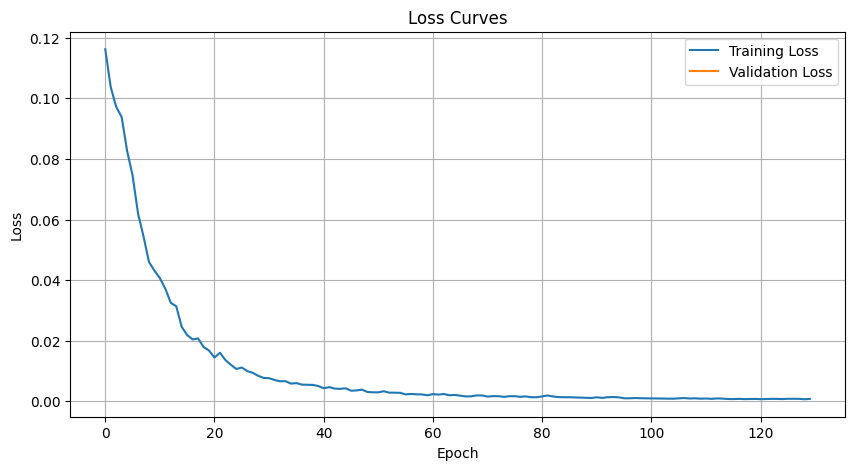

2024-11-15 21:06:22,305 - INFO - Final training loss: 0.0008
2024-11-15 21:06:22,394 - INFO - 提前6天预报 - RMSE: 0.0615, MAE: 0.0471
2024-11-15 21:06:22,394 - INFO - 
训练提前7天预报模型
2024-11-15 21:06:29,288 - INFO - Epoch 10/200, Average Loss: 0.0306
2024-11-15 21:06:35,912 - INFO - Epoch 20/200, Average Loss: 0.0160
2024-11-15 21:06:42,663 - INFO - Epoch 30/200, Average Loss: 0.0084
2024-11-15 21:06:49,091 - INFO - Epoch 40/200, Average Loss: 0.0055
2024-11-15 21:06:55,691 - INFO - Epoch 50/200, Average Loss: 0.0033
2024-11-15 21:07:03,364 - INFO - Epoch 60/200, Average Loss: 0.0021
2024-11-15 21:07:11,001 - INFO - Epoch 70/200, Average Loss: 0.0017
2024-11-15 21:07:18,176 - INFO - Epoch 80/200, Average Loss: 0.0016
2024-11-15 21:07:24,859 - INFO - Epoch 90/200, Average Loss: 0.0011
2024-11-15 21:07:32,235 - INFO - Epoch 100/200, Average Loss: 0.0012
2024-11-15 21:07:37,086 - INFO - Early stopping at epoch 106


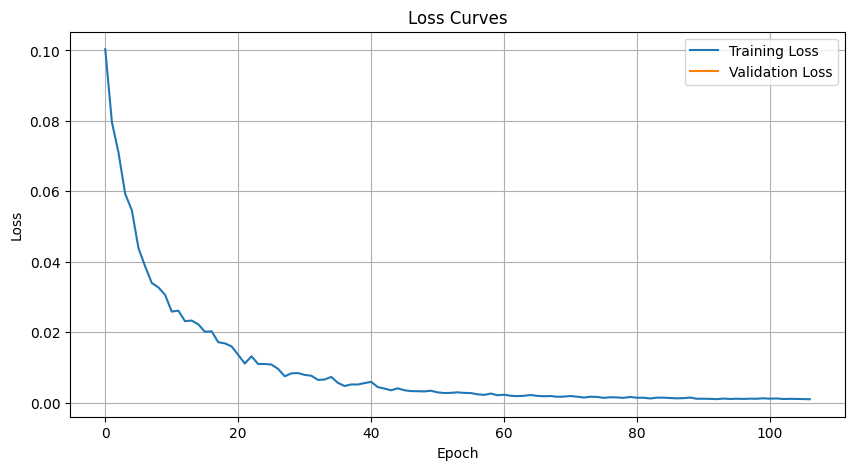

2024-11-15 21:07:37,217 - INFO - Final training loss: 0.0009
2024-11-15 21:07:37,260 - INFO - 提前7天预报 - RMSE: 0.0467, MAE: 0.0363
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_7207/3936125521.py:323: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/

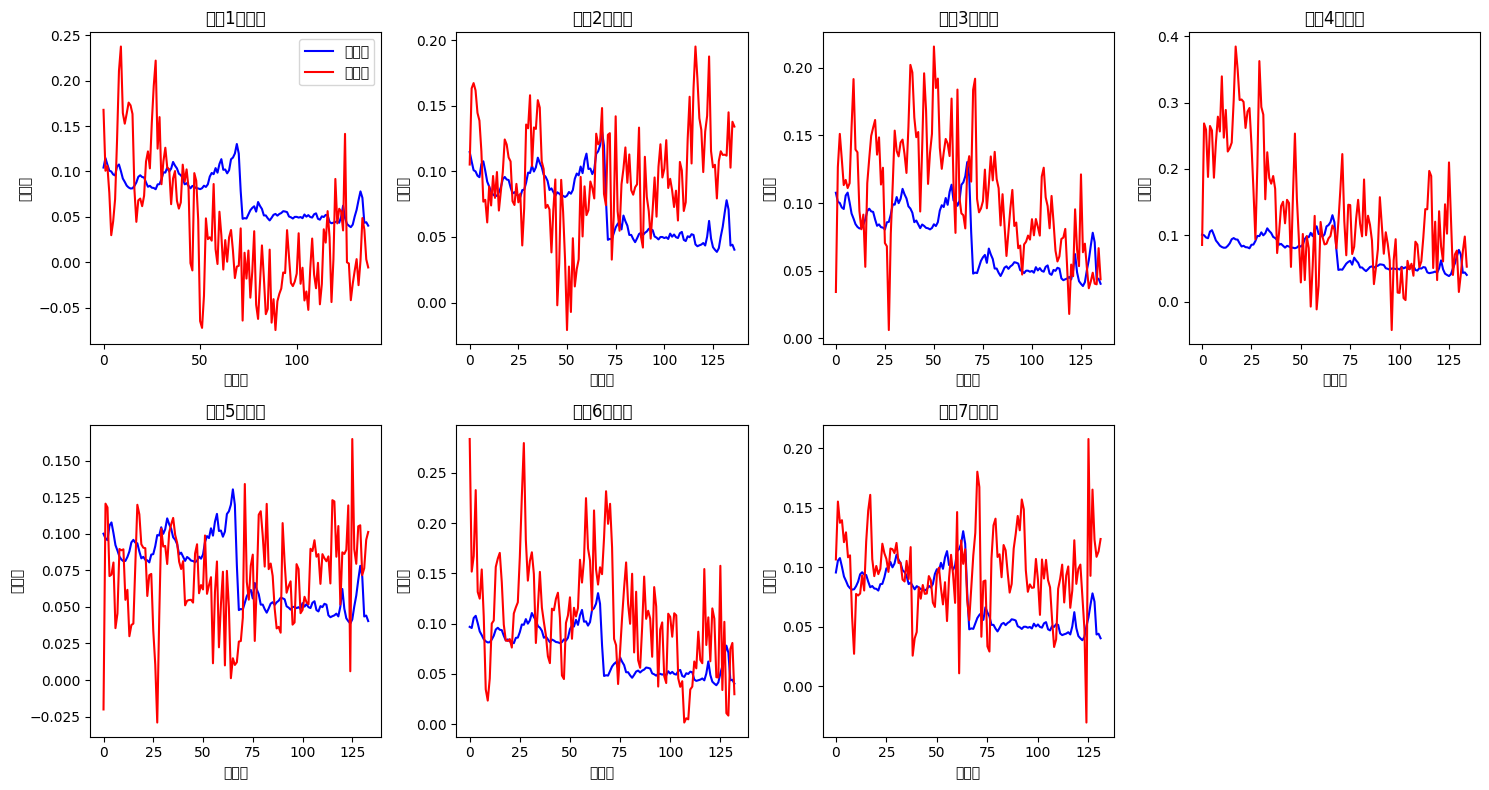

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

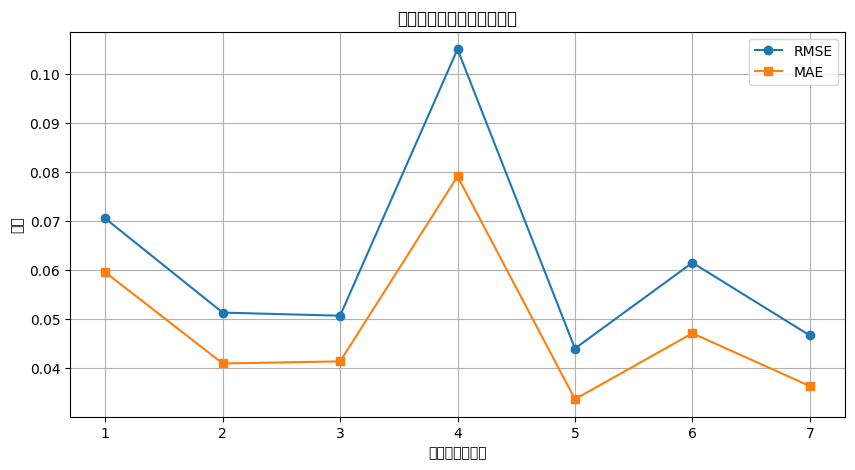

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        if out.size(2) != residual.size(2):
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 添加注意力机制，特别关注最近的历史数据
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        
        # 增加残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.batch_norm(x)
        out = self.tcn(x)
        
        # 应用注意力机制
        out = out.transpose(1, 2)  # 调整维度以适应注意力层
        attn_out, _ = self.attention(out, out, out)
        out = attn_out[:, -1, :]  # 取最后一个时间步
        
        out = self.fc_layers(out)
        
        # 添加残差连接，特别是对最近的历史数据
        residual = self.residual(x[:, :, -1])
        out = out + residual
        
        return out

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对所有特征进行归一化
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), 
                           columns=all_features, 
                           index=df.index)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
    
    return train_data_dict, test_data_dict, scaler, all_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = nn.HuberLoss()
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)  # 输入特征维度会增加
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = TCNModel(input_size, hidden_size, num_layers, output_size, 
                           kernel_size=3, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()